# Readout error mitigation

This page explains the concept of readout (measurement) error and how to use the [mthree](https://qiskit.org/ecosystem/mthree/) software package to mitigate readout error for the Sampler primitive (the Estimator primitive has built-in support for readout error mitigation).

Readout error (also known as measurement error) is the error that occurs when qubits are measured, that is, when they are "read out" into classical bits. It is a common source of error in noisy quantum devices. Mathematically, readout error is modeled as a classical channel that alters the probability distribution of the measured bits. Concretely, if we have $n$ qubits and $\vec{p}_\text{ideal}$ is a vector containing the probabilities of measuring each bitstring in the absence of readout error (so $\vec{p}_\text{ideal}$ has length $2^n$), then the effect of readout error is to alter these probabilities via multiplication by a matrix $M$:

$$
\vec{p}_\text{noisy} = M \vec{p}_\text{ideal}.
$$

Here, $\vec{p}_\text{noisy}$ is the noisy probability distribution that would actually be observed in experiment. The basic idea of readout error mitigation is to recover $\vec{p}_\text{ideal}$ by applying the inverse of $M$:

$$
\vec{p}_\text{ideal} = M^{-1}\vec{p}_\text{noisy}.
$$

Since $M$ has dimenstions $2^n \times 2^n$, explicitly computing all of its entries is not practical in the general case. In practice, readout error is usually approximately local (that is, the errors for one qubit are correlated with those of at most a few other qubits), so it can be described using much less information. In the simplest case, the readout error for each qubit is independent of all other qubits.

Readout error can be simulated using [Qiskit Aer](https://qiskit.org/ecosystem/aer/). In the following code cell, we construct a noise model that has independent readout error for each qubit, such that
- A readout of 1 has a 5% probability of being erroneously read as 0.
- A readout of 0 has a 2% probability of being erroneously read as 1.

Then, we initialize a simulator backend with the noise model.

In [1]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError

noise_model = NoiseModel()

p0given1 = 0.05
p1given0 = 0.02
readout_error = ReadoutError(
    [
        [1 - p1given0, p1given0],
        [p0given1, 1 - p0given1],
    ]
)
noise_model.add_all_qubit_readout_error(readout_error)

sim = AerSimulator(noise_model=noise_model, seed_simulator=1234)

Let's construct a simple circuit to test on. In the following code cell, we create a two-qubit circuit that applies a Hadamard gate on each qubit, and then measures them. Since the final state before measurement is an equal superposition of all computational basis states, the ideal probability distribution is equally distributed over all four outcomes.

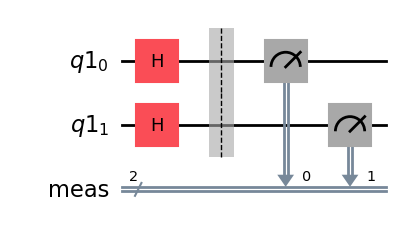

In [2]:
from qiskit import QuantumCircuit, QuantumRegister

qubits = QuantumRegister(2)
circuit = QuantumCircuit(qubits)

a, b = qubits
circuit.h(a)
circuit.h(b)
circuit.measure_all()
circuit.draw("mpl")

In the following code cell, we transpile the circuit, run it using the Sampler primitive, and plot the probability distribution of the returned bitstring counts.

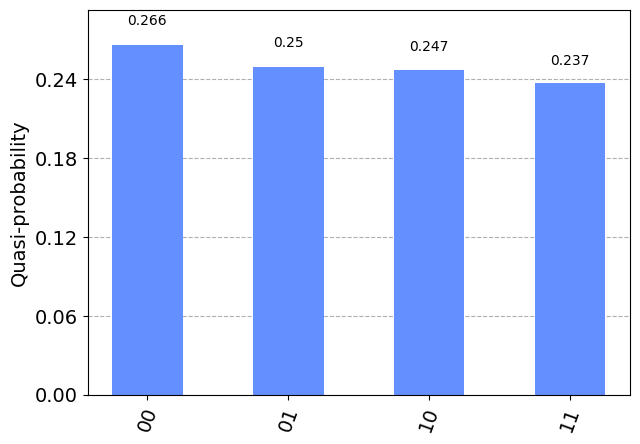

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, seed_transpiler=1234
)
isa_circuit = pass_manager.run(circuit)
isa_circuit.draw("mpl", idle_wires=False)

sampler = Sampler(backend=sim)
pubs = [(isa_circuit, None, 10000)]
job = sampler.run(pubs)
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()
plot_distribution(counts)

Due to the readout error, the results deviate significantly from the ideal distribution, which would have 0.25 probability for each bitstring. In accordance with the noise model, each qubit is more likely to be read as 0 than 1.

In the following code cell, we show how to use [mthree](https://qiskit.org/ecosystem/mthree/) to mitigate the effect of readout error. There are several steps:
- Read the final qubit mapping of the transpiled circuit so that mthree knows which qubits need to be calibrated.
- Calibrate the readout error using an `mthree.M3Mitigation` object. In this step, mthree runs some circuits on the backend in order to estimate the readout error.
- Apply the correction to the bitstring counts.

The resulting distribution is much closer to the ideal one.

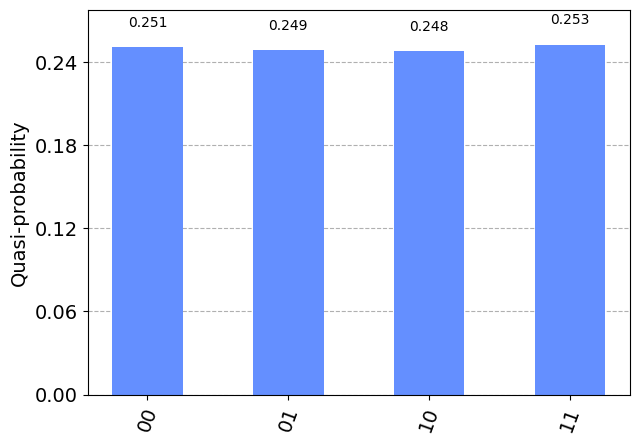

In [4]:
import mthree

# retrieve the final qubit mapping so mthree knows which qubits to calibrate
mapping = mthree.utils.final_measurement_mapping(isa_circuit)

# calibrate readout error
mit = mthree.M3Mitigation(sim)
mit.cals_from_system(mapping)

# mitigate readout error
quasis = mit.apply_correction(counts, mapping)

# plot mitigated distribution
plot_distribution(quasis)

The output of the readout error mitigation is a quasiprobability distribution over the possible bitstring outcomes. A quasiprobability distribution is similar to a probability distribution, but it may contain negative "probabilities." These negative values occur due to finite sampling statistical error in the readout error calibration. A quasiprobability distribution still sums to one and can be used to compute expectation values. If a true probability distribution is needed, you can obtain the nearest probability distribution (in terms of $L_2$ norm) using the `nearest_probability_distribution` method:

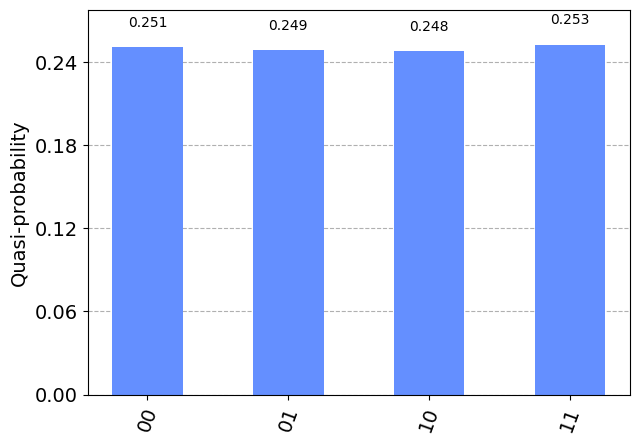

In [5]:
probs = quasis.nearest_probability_distribution()

plot_distribution(probs)

In this case, the quasiprobability distribution did not contain any negative values, so it was already a true probability distribution.